In [1]:
import openml
import numpy as np

# Import danych

In [2]:
datasets = {}

### Diabetes

In [3]:
diabetes_dataset = openml.datasets.get_dataset(37)

In [4]:
X, y, _, columns = diabetes_dataset.get_data(target=diabetes_dataset.default_target_attribute)

In [5]:
datasets['diabetes'] = [X, y, columns]

### Credit-g

In [6]:
creditg_dataset = openml.datasets.get_dataset(31)

In [7]:
X, y, _, columns = creditg_dataset.get_data(target=creditg_dataset.default_target_attribute)

In [8]:
datasets['creditg'] = [X, y, columns]

### Spambase

In [9]:
spambase_dataset = openml.datasets.get_dataset(44)

In [10]:
X, y, _, columns = spambase_dataset.get_data(target=spambase_dataset.default_target_attribute)

In [11]:
datasets['spambase'] = [X, y, columns]

### Yeast

In [12]:
yeast_dataset = openml.datasets.get_dataset(40597)

In [13]:
X, y, _, _ = yeast_dataset.get_data(target="Class1")
X = X.drop(columns=['Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10',  'Class11',  'Class12',  'Class13',  'Class14'])


In [14]:
datasets['yeast'] = [X, y, columns]

# Preprocessing

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector

In [16]:
# Setting preprocessing and model

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

col_trans = ColumnTransformer(transformers=[
        ('num_pipeline', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat_pipeline', cat_pipeline, make_column_selector(dtype_include='category'))
    ],
    remainder='passthrough',
    n_jobs=-1
)

def label_encode(y):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(y)

target_transformer = FunctionTransformer(label_encode, validate=False)

LR = LogisticRegression(penalty='elasticnet', solver='saga', class_weight='balanced', l1_ratio=0.5)
model_pipe = Pipeline([('preprocessing', col_trans), ('model', LR)])
model_pipe.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(n_jobs=-1, remainder='passthrough',
                     transformers=[('num_pipeline',
                                    Pipeline(steps=[('impute', SimpleImputer()),
                                                    ('scale', MinMaxScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000002542D37BE60>),
                                   ('cat_pipeline',
                                    Pipeline(steps=[('impute',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('one-hot',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse_output=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector objec

# Szukanie hiperparametrów domyślnych

In [17]:
import pandas as pd
from time import time
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
import json

In [18]:
# Definicja modelu i parametrów do przeszukiwania
rf = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': [50, 100, 200, 300, 1000, 1500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [19]:
# Przeprowadzenie Random Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

In [20]:
# Przechowujemy wyniki dla każdego zbioru danych
all_results = []

# Przeprowadzamy Random Search dla każdego zbioru danych
for dataset_name in datasets:
    start_time_iter = time()
    print(f"Dataset: {dataset_name}")
    
    # Ekstrakcja danych
    dataset = datasets[dataset_name]
    X = dataset[0]
    y = target_transformer.fit_transform(dataset[1])  # Target transformation
    
    # Transformacja cech
    X = col_trans.fit_transform(X)
    
    # Podział na dane treningowe i testowe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Dopasowanie modelu
    random_search.fit(X_train, y_train)
    
    # Zbieranie wyników każdej iteracji z Random Search dla bieżącego zbioru danych
    dataset_results = pd.DataFrame(random_search.cv_results_)
    dataset_results['dataset'] = dataset_name
    
    # Zamiana słownika z parametrami na tekstowy format JSON
    dataset_results['params'] = dataset_results['params'].apply(lambda x: str(x))
    
    # Zapis wyników dla bieżącego zbioru danych do ogólnej listy
    all_results.append(dataset_results[['params', 'mean_test_score', 'dataset']])

    # Odliczanie czasu całego algorytmu
    elapsed_time_iter = time() - start_time_iter
    print(f"Czas wykonaniu dla datasetu {dataset_name}: {elapsed_time_iter}")

Dataset: diabetes
Czas wykonaniu dla datasetu diabetes: 34.16269874572754
Dataset: creditg
Czas wykonaniu dla datasetu creditg: 34.753427267074585
Dataset: spambase
Czas wykonaniu dla datasetu spambase: 120.01265048980713
Dataset: yeast
Czas wykonaniu dla datasetu yeast: 355.6644780635834


In [21]:
# Konwersja wyników do DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

# Grupowanie po parametrach i obliczenie średniej AUC
mean_results_df = (
    all_results_df.groupby('params')['mean_test_score']
    .mean()
    .reset_index()
    .rename(columns={'mean_test_score': 'mean_auc'})
)

# Znalezienie najlepszego zestawu hiperparametrów
default_params = mean_results_df.loc[mean_results_df['mean_auc'].idxmax()]

# Zapisz szukanie
mean_results_df.to_csv(f"output/default_value_iter.csv", index=False)
default_params.to_csv(f"output/default_value_best.csv", index=False)

# Wyświetlanie najlepszego zestawu hiperparametrów i jego średniej wartości AUC
print("Best Parameters:")
print(default_params)

Best Parameters:
params      {'n_estimators': 1500, 'min_samples_split': 5,...
mean_auc                                              0.85539
Name: 24, dtype: object


In [22]:
import ast

# Konwersja stringa na słownik
default_params_dict = ast.literal_eval(default_params['params'])

# Random Search Optymalizacja

In [23]:
import warnings

# Wyłączenie FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning

# Ignorowanie wszystkich UserWarnings (np. z skopt) oraz ConvergenceWarnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [26]:
default_stats = {}

# Obliczanie dla każdego datasetu
for i, dataset_name in enumerate(datasets):
    start_time_iter = time()
    
    print(f"Dataset: {dataset_name}")
    # Eksportowanie datasetu
    dataset = datasets[dataset_name]
    X = dataset[0]
    y = dataset[1]
    columns = dataset[2]
    
    y = target_transformer.fit_transform(y)

    X = col_trans.fit_transform(X)

    # Konwersja do DataFrame, jeśli X nie jest DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
        
    # Podział na dane treningowe i testowe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Trenowanie i ewaluacja modelu z walidacją krzyżową 5-krotną
    rf_best = RandomForestClassifier(random_state=42, **default_params_dict)
    
    # 5-krotna walidacja krzyżowa z metryką AUC
    cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Średnia AUC z walidacji krzyżowej
    mean_cv_auc = cv_scores.mean()

    # Wartość AUC dla wartości domyślnej
    default_stats[dataset_name] = mean_cv_auc
    
    # Unoptimized
    start_time = time()
    model_pipe.fit(X_train,y_train)
    elapsed_time = time() - start_time
    
    y_pred = model_pipe.predict(X_test)
    auc_scr = roc_auc_score(y_test, y_pred)
    r2_scr = r2_score(y_test, y_pred)
    
    new_row = pd.DataFrame({
      'method': "Unoptimized",
      'elapsed_time': [elapsed_time],
      'best_score': None,
      'test_score': None,
      'best_params': f"[\'model__C\': {LR.get_params()['C']}, \'model__l1_ratio\':{LR.get_params()['l1_ratio']}]",
      'auc_score': [auc_scr],
      'tunability': [mean_cv_auc - auc_scr],
      'r2_score': [r2_scr]
    })
    main_results_df = pd.DataFrame(columns=['method','elapsed_time', 'best_score', 'test_score', 'best_params', 'auc_score','tunability', 'r2_score'])
    main_results_df = pd.concat([main_results_df, new_row], ignore_index=True)

    # Random Search
    start_time = time()
    random_search.fit(X_train, y_train)
    elapsed_time = time() - start_time
    
    best_score = random_search.best_score_
    test_score = random_search.score(X_test, y_test)
    best_params = str(random_search.best_params_)
    
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    auc_scr = roc_auc_score(y_test, y_pred)
    r2_scr = r2_score(y_test, y_pred)
    
    random_results = pd.DataFrame(random_search.cv_results_)
    random_results['search_type'] = 'RandomizedSearchCV'
    
    new_row = pd.DataFrame({
        'method': "RandomSearchCV",
        'elapsed_time': [elapsed_time],
        'best_score': [best_score],
        'test_score': [test_score],
        'best_params': [best_params],
        'auc_score': [auc_scr],
        'tunability': [mean_cv_auc - auc_scr],
        'r2_score': [r2_scr]
    })
    main_results_df = pd.concat([main_results_df, new_row], ignore_index=True)

    name = "random_search"
    main_results_df.to_csv(f"output/{dataset_name}_{name}_main_res.csv", index=False)
    random_results.to_csv(f"output/{dataset_name}_{name}_iter_res.csv", index=False)

    # Odliczanie czasu całego algorytmu
    elapsed_time_iter = time() - start_time_iter
    print(f"Czas wykonaniu dla datasetu {dataset_name}: {elapsed_time_iter}")


Dataset: diabetes
Czas wykonaniu dla datasetu diabetes: 45.55674886703491
Dataset: creditg
Czas wykonaniu dla datasetu creditg: 49.38342618942261
Dataset: spambase
Czas wykonaniu dla datasetu spambase: 152.9293339252472
Dataset: yeast
Czas wykonaniu dla datasetu yeast: 442.0696280002594


diabetes
default hyperparameters 0.8380570252792475
max 0.8438165135419657
d 0.005759488262718215


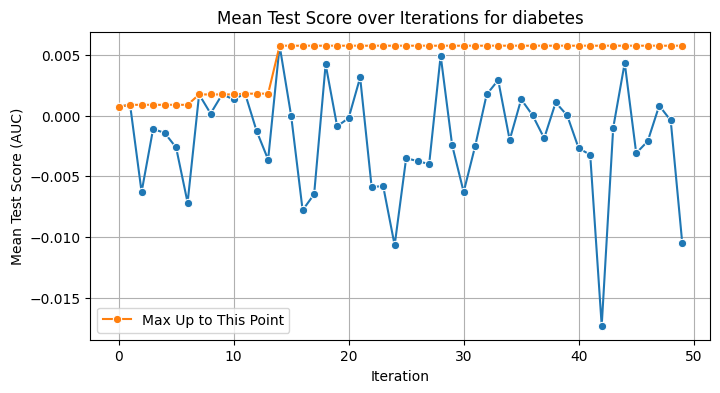

creditg
default hyperparameters 0.7870854591836735
max 0.7922271442360728
d 0.005141685052399314


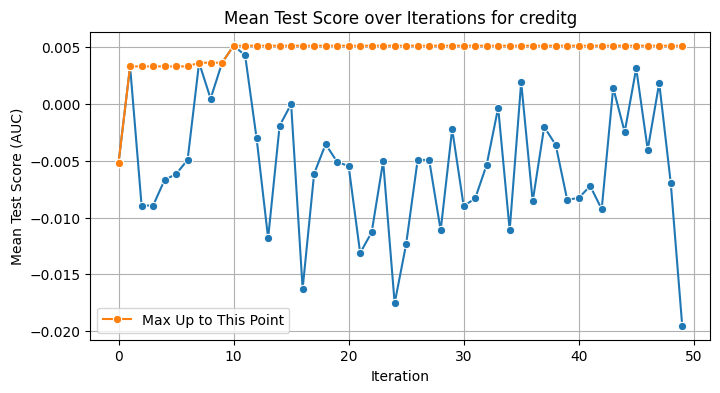

spambase
default hyperparameters 0.986622225664369
max 0.9874609775726914
d 0.0008387519083223882


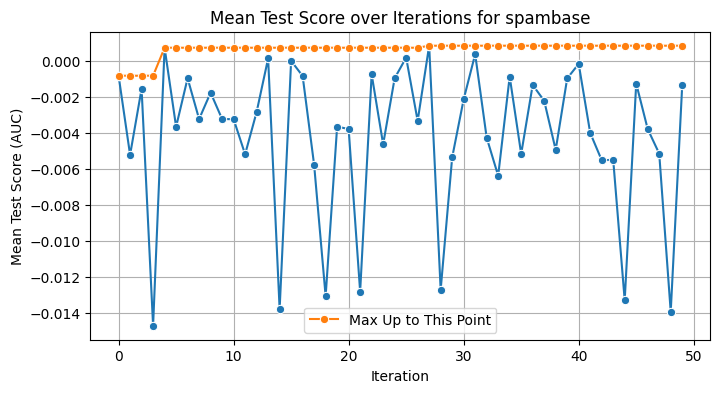

yeast
default hyperparameters 0.8097937045017571
max 0.8104194587444236
d 0.0006257542426664209


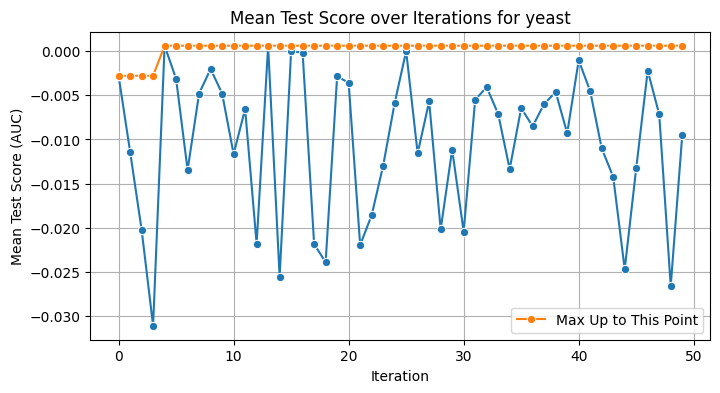

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# DataFrame do przechowywania wyników dla każdego datasetu
all_data_random = pd.DataFrame()

# Iteracja przez wszystkie datay i generowanie wykresów
for dataset_name in datasets:
    print(dataset_name)
    
    default_auc_score = default_stats[dataset_name]
    print("default hyperparameters", default_auc_score)
    
    # Wczytaj wyniki dla danego datasetu z pliku
    random_results = pd.read_csv(f"output/{dataset_name}_random_search_iter_res.csv")
    
    max_mean_test_score = random_results['mean_test_score'].max()
    min_mean_test_score = random_results['mean_test_score'].min()
    
    print('max', max_mean_test_score)
    print('d', max_mean_test_score - default_auc_score)
    
    # Dodanie nowej kolumny z różnicą między mean_test_score a default_auc_score
    random_results['adjusted_mean_test_score'] = -(default_auc_score - random_results['mean_test_score']) #/ ( max_mean_test_score - min_mean_test_score)

    # Dodanie kolumny max_adjusted_mean_test_score_in_window (maksymalna wartość z wszystkich poprzednich wierszy)
    random_results['max_adjusted_mean_test_score_in_window'] = random_results['adjusted_mean_test_score'].cummax()
    random_results['dataset'] = dataset_name
    
    # Dołączamy wyniki do all_data
    all_data_random = pd.concat([all_data_random, random_results[['dataset', 'adjusted_mean_test_score']]])

    # Tworzenie wykresu
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=random_results, x=random_results.index, y='adjusted_mean_test_score', marker='o')
    sns.lineplot(data=random_results, x=random_results.index, y='max_adjusted_mean_test_score_in_window', marker='o', label='Max Up to This Point')
    plt.title(f"Mean Test Score over Iterations for {dataset_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Test Score (AUC)")
    plt.grid(True)
    plt.show()

# d 0.005930488905295128
# d 0.005518018018017989
# d 0.0007703740972345718
# d 0.00046967973840550403

In [37]:
def show_boxplot(all_data):
    # Rysowanie boxplotu i dodanie punktów dla każdej wartości
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    
    # Wykres boxplot
    sns.boxplot(data=all_data, x='dataset', y='adjusted_mean_test_score', palette="Set2")
    
    # Wykres stripplot do pokazania punktów danych
    sns.stripplot(data=all_data, x='dataset', y='adjusted_mean_test_score', 
                  jitter=True, color='black', alpha=0.6, marker="o")
    
    plt.title("Boxplot of Adjusted Mean Test Score with Points for Each Dataset")
    plt.xlabel("Dataset")
    plt.ylabel("Adjusted Mean Test Score (AUC)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

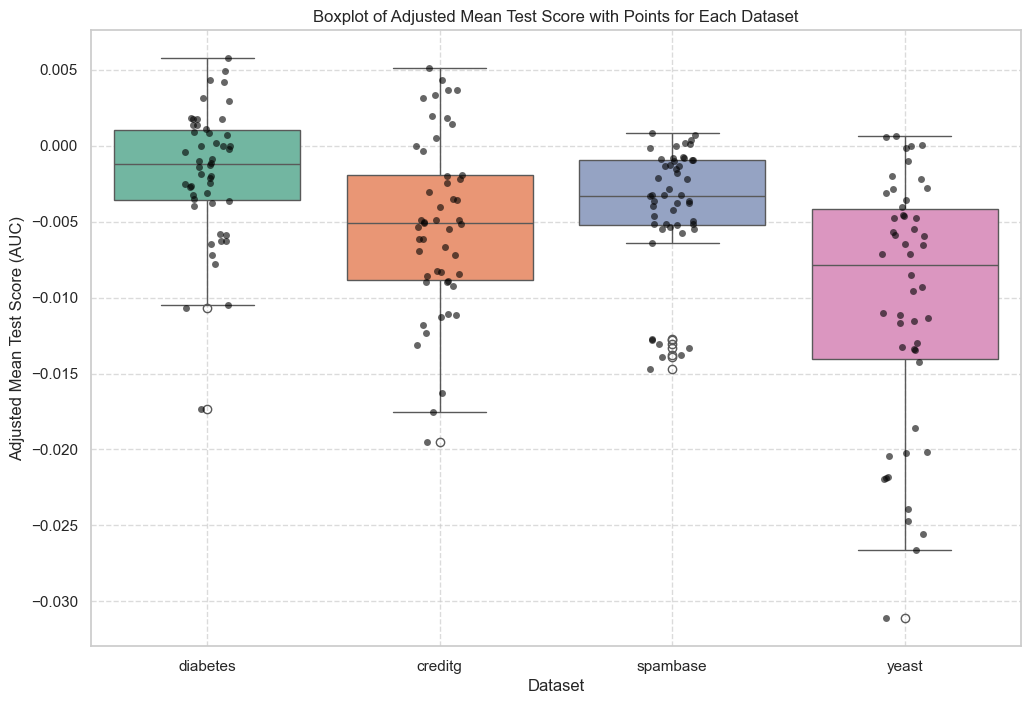

In [39]:
show_boxplot(all_data_random)

# Bayesian Optimization

In [41]:
# Definicja przestrzeni hiperparametrów

param_space = {
    'model__C': np.arange(0.005,1.0,0.005),                # Parametr C dla LogisticRegression
    'model__penalty': ['elasticnet'],        # Parametr penalty
    'model__l1_ratio': [0.2, 0.5, 0.8]       # Wartość l1_ratio dla elasticnet
}

bayes_search = BayesSearchCV(
    model_pipe,
    param_space,
    n_iter=60,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    return_train_score=True
)

In [42]:
default_stats_bayes = {}

# Obliczanie dla każdego datasetu
for i, dataset_name in enumerate(datasets):
    start_time_iter = time()
    
    print(f"Dataset: {dataset_name}")
    # Eksportowanie datasetu
    dataset = datasets[dataset_name]
    X = dataset[0]
    y = dataset[1]
    columns = dataset[2]
    
    y = target_transformer.fit_transform(y)

    X = col_trans.fit_transform(X)

    # Konwersja do DataFrame, jeśli X nie jest DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
        
    # Podział na dane treningowe i testowe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Trenowanie i ewaluacja modelu z walidacją krzyżową 5-krotną
    rf_best = RandomForestClassifier(random_state=42, **default_params_dict)
    
    # 5-krotna walidacja krzyżowa z metryką AUC
    cv_scores = cross_val_score(rf_best, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Średnia AUC z walidacji krzyżowej
    mean_cv_auc = cv_scores.mean()
    
    default_stats_bayes[dataset_name] = mean_cv_auc
    
    # Unoptimized
    start_time = time()
    model_pipe.fit(X_train,y_train)
    elapsed_time = time() - start_time
    
    y_pred = model_pipe.predict(X_test)
    auc_scr = roc_auc_score(y_test, y_pred)
    r2_scr = r2_score(y_test, y_pred)
    
    new_row = pd.DataFrame({
      'method': "Unoptimized",
      'elapsed_time': [elapsed_time],
      'best_score': None,
      'test_score': None,
      'best_params': f"[\'model__C\': {LR.get_params()['C']}, \'model__l1_ratio\':{LR.get_params()['l1_ratio']}]",
      'auc_score': [auc_scr],
      'r2_score': [r2_scr]
    })
    main_results_df = pd.DataFrame(columns=['method','elapsed_time', 'best_score', 'test_score', 'best_params', 'auc_score', 'r2_score'])
    main_results_df = pd.concat([main_results_df, new_row], ignore_index=True)

    # Bayes Search    
    start_time = time()
    bayes_search.fit(X_train, y_train)
    elapsed_time = time() - start_time
    
    best_score = bayes_search.best_score_
    test_score = bayes_search.score(X_test, y_test)
    best_params = str(bayes_search.best_params_)
    
    best_model = bayes_search.best_estimator_
    y_pred = best_model.predict(X_test)
    auc_scr = roc_auc_score(y_test, y_pred)
    r2_scr = r2_score(y_test, y_pred)
    
    bayes_results = pd.DataFrame(bayes_search.cv_results_)
    bayes_results['search_type'] = 'BayesSearchCV'
    
    new_row = pd.DataFrame({
        'method': "BayesSearchCV",
        'elapsed_time': [elapsed_time],
        'best_score': [best_score],
        'test_score': [test_score],
        'best_params': [best_params],
        'auc_score': [auc_scr],
        'r2_score': [r2_scr]
    })
    main_results_df = pd.concat([main_results_df, new_row], ignore_index=True)

    name = "bayes_search"
    main_results_df.to_csv(f"output/{dataset_name}_{name}_main_res.csv", index=False)
    bayes_results.to_csv(f"output/{dataset_name}_{name}_iter_res.csv", index=False)
    
    # Odliczanie czasu całego algorytmu
    elapsed_time_iter = time() - start_time_iter
    print(f"Czas wykonaniu dla datasetu {dataset_name}: {elapsed_time_iter}")


Dataset: diabetes
Czas wykonaniu dla datasetu diabetes: 651.2538390159607
Dataset: creditg
Czas wykonaniu dla datasetu creditg: 663.7288935184479
Dataset: spambase
Czas wykonaniu dla datasetu spambase: 808.2241456508636
Dataset: yeast
Czas wykonaniu dla datasetu yeast: 1000.5178375244141


diabetes
default hyperparameters 0.8380570252792475
max 0.8334373760988749
d -0.004619649180372609


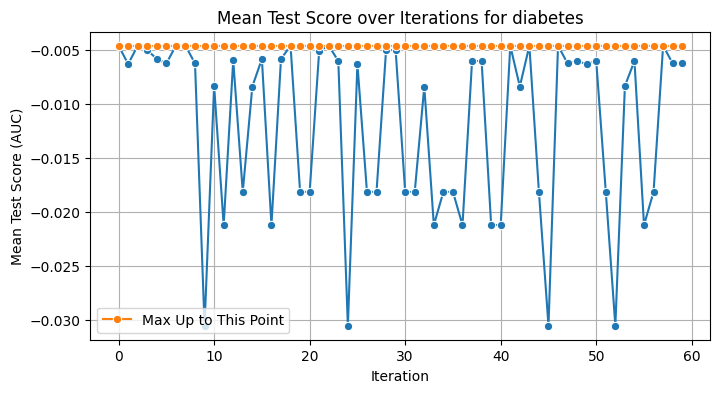

creditg
default hyperparameters 0.7870854591836735
max 0.7700798055708771
d -0.01700565361279638


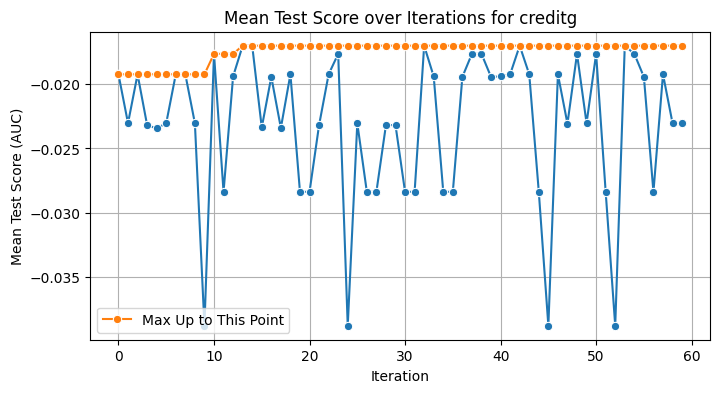

spambase
default hyperparameters 0.986622225664369
max 0.9696137469069224
d -0.0170084787574466


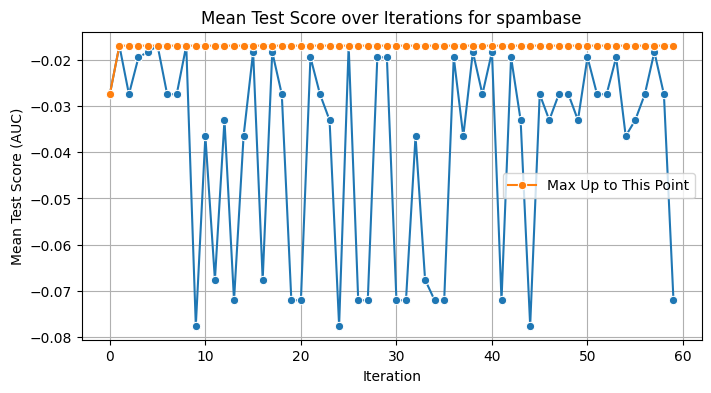

yeast
default hyperparameters 0.8097937045017571
max 0.7883052164350564
d -0.021488488066700784


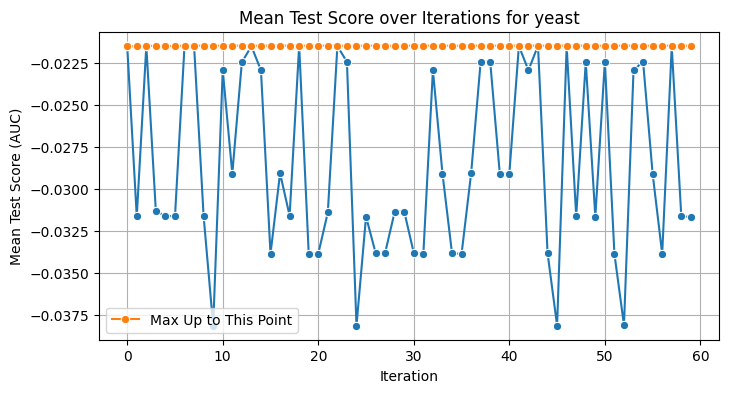

In [31]:
# DataFrame do przechowywania wyników dla każdego datasetu
all_data_bayes = pd.DataFrame()

# Iteracja przez wszystkie datay i generowanie wykresów
for dataset_name in datasets:
    print(dataset_name)

    default_auc_score = default_stats_bayes[dataset_name]
    print("default hyperparameters", default_auc_score)
    
    # Wczytaj wyniki dla danego datasetu z pliku
    bayes_results = pd.read_csv(f"output/{dataset_name}_bayes_search_iter_res.csv")
    
    max_mean_test_score = bayes_results['mean_test_score'].max()
    min_mean_test_score = bayes_results['mean_test_score'].min()
    print('max', max_mean_test_score)
    print('d', (max_mean_test_score - default_auc_score))
    
    # Dodanie nowej kolumny z różnicą między mean_test_score a default_auc_score
    bayes_results['adjusted_mean_test_score'] = - (default_auc_score - bayes_results['mean_test_score']) #/ (max_mean_test_score - min_mean_test_score)

    # Dodanie kolumny max_adjusted_mean_test_score_in_window (maksymalna wartość z wszystkich poprzednich wierszy)
    bayes_results['max_adjusted_mean_test_score_in_window'] = bayes_results['adjusted_mean_test_score'].cummax()

    bayes_results['dataset'] = dataset_name
    
    # Dołączamy wyniki do all_data
    all_data_bayes = pd.concat([all_data_bayes, bayes_results[['dataset', 'adjusted_mean_test_score']]])
    
    # Tworzenie wykresu
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=bayes_results, x=bayes_results.index, y='adjusted_mean_test_score', marker='o')
    sns.lineplot(data=bayes_results, x=bayes_results.index, y='max_adjusted_mean_test_score_in_window', marker='o', label='Max Up to This Point')
    plt.title(f"Mean Test Score over Iterations for {dataset_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Test Score (AUC)")
    plt.grid(True)
    plt.show()

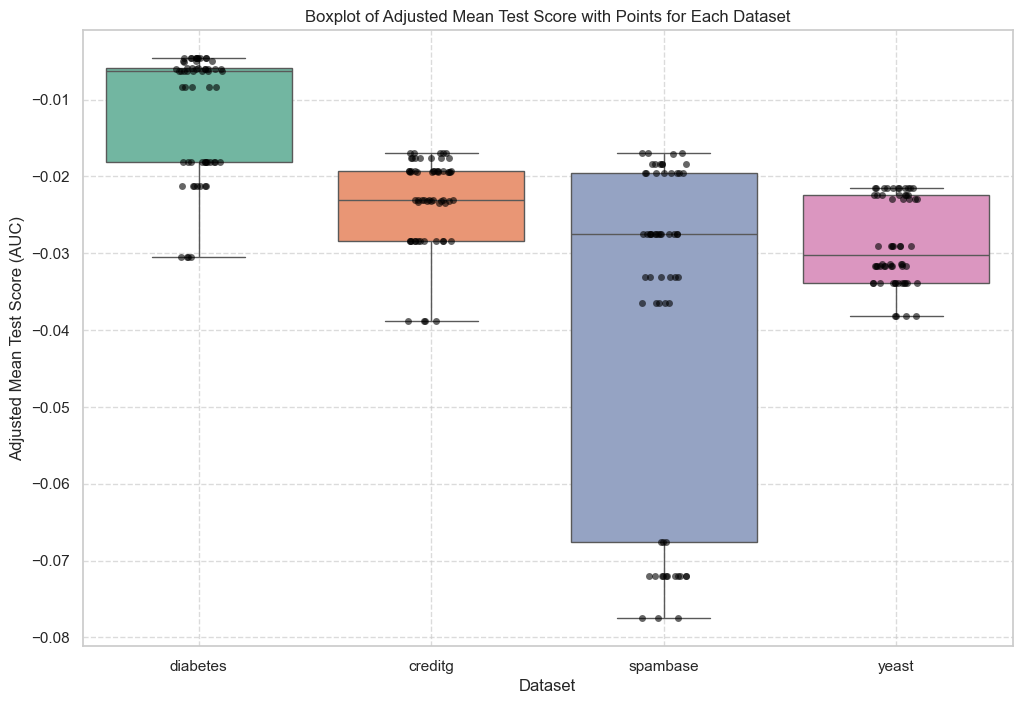

In [40]:
show_boxplot(all_data_bayes)